In [426]:
from graphdatascience import GraphDataScience

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

# neo4j desktop (5.3.0, m1)

In [427]:
host = "bolt://localhost:7687"
user = "neo4j"
password= "j4oenj4oen"

gds = GraphDataScience(host, auth=(user, password))
print(gds.version())

2.3.2


# 1. Import Data into Neo4j

In [428]:
query = """
CREATE CONSTRAINT constraint_article IF NOT EXISTS
For (article:Article) REQUIRE article.index IS UNIQUE
"""
gds.run_cypher(query)

query = """
CREATE CONSTRAINT constraint_author IF NOT EXISTS 
For (author:Author) REQUIRE author.name IS UNIQUE
"""
gds.run_cypher(query)

query = """
CALL apoc.periodic.iterate(
'UNWIND ["dblp-ref-0.json","dblp-ref-1.json", "dblp-ref-2.json","dblp-ref-3.json"] AS file 
CALL apoc.load.json("file:///" + file) 
YIELD value WHERE value.venue IN ["Lecture Notes in Computer Science", "Communications of The ACM", "international conference on software engineering", "advances in computing and communications"]
return value', 
'MERGE (a:Article {index:value.id}) ON CREATE SET a += apoc.map.clean(value,["id","authors","references"],[0]) WITH a, value.authors as authors 
UNWIND authors as author 
MERGE (b:Author {name:author}) 
MERGE (b)<-[:AUTHOR]-(a)', 
{batchSize:10000, parallel:true});
"""
gds.run_cypher(query)

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,6,51956,18,51956,0,0,0,{},"{'total': 6, 'committed': 6, 'failed': 0, 'err...","{'total': 51956, 'committed': 51956, 'failed':...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 132255, 're..."


# 2. The Coauthorship Graph

In [429]:
query = """
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author) 
WITH a1, a2, paper 
ORDER BY a1, paper.year 
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations 
MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2) 
SET coauthor.collaborations = collaborations;
"""
gds.run_cypher(query)

""


# 3. Create Training and Testing Datasets

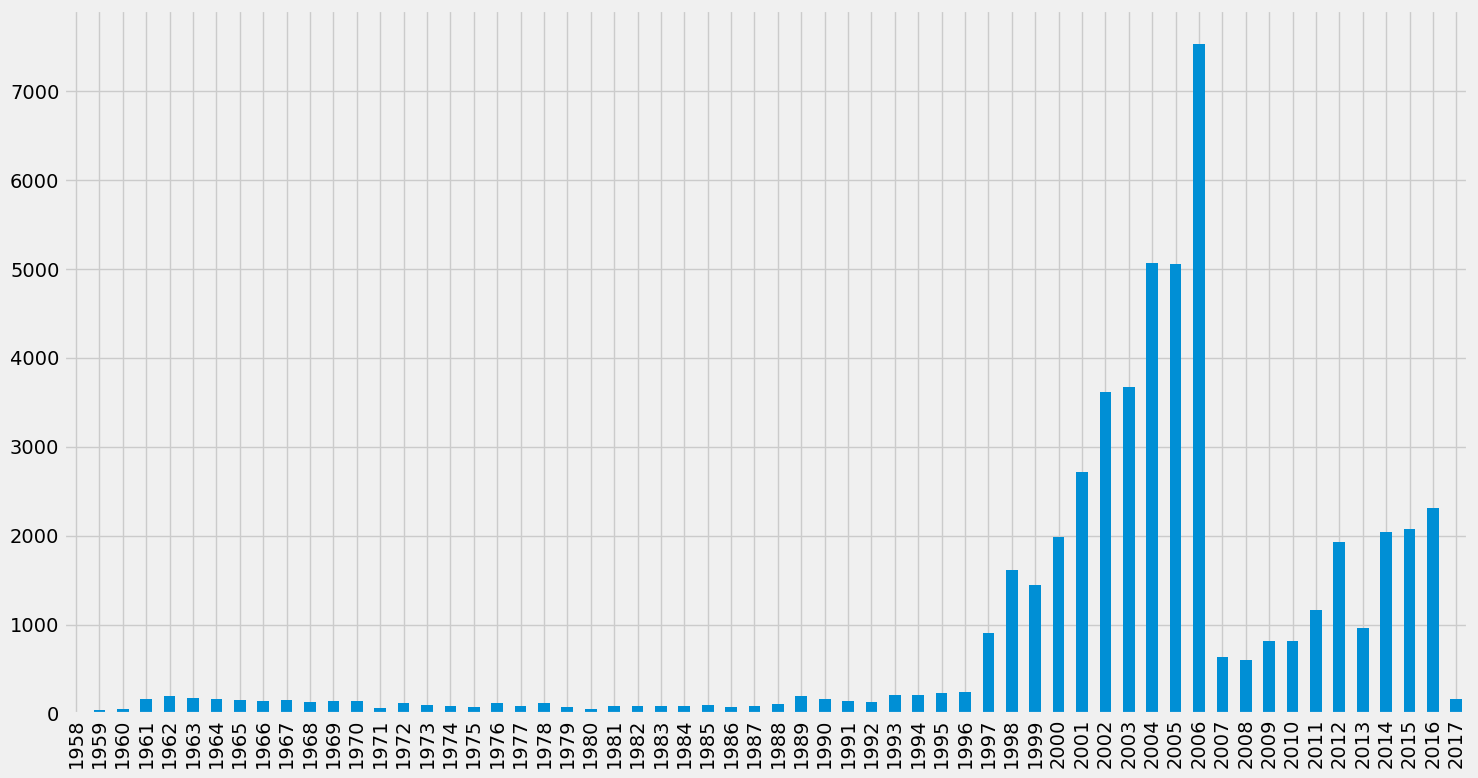

In [430]:
query = """
MATCH (article:Article) 
RETURN article.year AS year, count(*) AS count
ORDER BY year 
"""
by_year = gds.run_cypher(query)

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8)) 
ax.xaxis.set_label_text("") 
plt.tight_layout() 
# plt.show()
plt.savefig("figs/by_year.jpg")

# 4. Project Graph

In [431]:
exists_result = gds.graph.exists("myGraph")
if exists_result["exists"]:
    G = gds.graph.get("myGraph")
    G.drop()

G, _ = gds.graph.project(
    "myGraph",
    ["Author"],
    {"CO_AUTHOR": {"orientation": "UNDIRECTED"}}
)

In [432]:

gds.triangleCount.write.estimate(
    G,
    nodeLabels=["Author"],
    relationshipTypes=["CO_AUTHOR"],
    writeProperty="triangles"
)

requiredMemory                                                 627 KiB
treeView             Memory Estimation: 627 KiB\n|-- algorithm: 627...
mapView              {'components': [{'components': [{'memoryUsage'...
bytesMin                                                        642552
bytesMax                                                        642552
nodeCount                                                        80299
relationshipCount                                               310448
heapPercentageMin                                                  0.1
heapPercentageMax                                                  0.1
Name: 0, dtype: object

In [433]:
gds.triangleCount.write(
    G,
    nodeLabels=["Author"],
    relationshipTypes=["CO_AUTHOR"],
    writeProperty="triangles"
)

writeMillis                                                            110
nodePropertiesWritten                                                80299
globalTriangleCount                                                 199813
nodeCount                                                            80299
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                           26
configuration            {'jobId': '581a3820-efd2-4099-840c-afd6bc3a7e1...
Name: 0, dtype: object

In [434]:
gds.localClusteringCoefficient.write.estimate(
    G,
    nodeLabels=["Author"],
    relationshipTypes=["CO_AUTHOR"],
    writeProperty="coefficient"
)

requiredMemory                                                1254 KiB
treeView             Memory Estimation: 1254 KiB\n|-- algorithm: 12...
mapView              {'components': [{'components': [{'memoryUsage'...
bytesMin                                                       1285080
bytesMax                                                       1285080
nodeCount                                                        80299
relationshipCount                                               310448
heapPercentageMin                                                  0.1
heapPercentageMax                                                  0.1
Name: 0, dtype: object

In [435]:
gds.localClusteringCoefficient.write(
    G,
    nodeLabels=["Author"],
    relationshipTypes=["CO_AUTHOR"],
    writeProperty="coefficient"
)

writeMillis                                                                   339
nodePropertiesWritten                                                       80299
averageClusteringCoefficient                                             0.656957
nodeCount                                                                   80299
postProcessingMillis                                                            0
preProcessingMillis                                                             0
computeMillis                                                                  28
configuration                   {'jobId': '04a0a8bd-6f10-47e3-8d41-f26240719ae...
Name: 0, dtype: object

In [436]:
gds.labelPropagation.write.estimate(
    G,
    nodeLabels=["Author"],
    relationshipTypes=["CO_AUTHOR"],
    writeProperty="partition"
)

requiredMemory                                  [629 KiB ... 8820 KiB]
treeView             Memory Estimation: [629 KiB ... 8820 KiB]\n|--...
mapView              {'components': [{'components': [{'memoryUsage'...
bytesMin                                                        644448
bytesMax                                                       9032544
nodeCount                                                        80299
relationshipCount                                               310448
heapPercentageMin                                                  0.1
heapPercentageMax                                                  0.1
Name: 0, dtype: object

In [437]:
gds.labelPropagation.write(
    G,
    nodeLabels=["Author"],
    relationshipTypes=["CO_AUTHOR"],
    writeProperty="partition"
)

writeMillis                                                            424
nodePropertiesWritten                                                80299
ranIterations                                                           10
didConverge                                                          False
communityCount                                                       16015
communityDistribution    {'p99': 38, 'min': 1, 'max': 882, 'mean': 5.01...
postProcessingMillis                                                     4
preProcessingMillis                                                      0
computeMillis                                                          249
configuration            {'jobId': 'a1e9b4ae-1a2a-4cca-bca9-7291716f334...
Name: 0, dtype: object

In [438]:
query = """
CALL gds.louvain.stream.estimate("myGraph", {
  nodeLabels: ["Author"],
  relationshipTypes: ["CO_AUTHOR"],
  includeIntermediateCommunities: true
})
"""
gds.run_cypher(query)

,requiredMemory,treeView,mapView,bytesMin,bytesMax,nodeCount,relationshipCount,heapPercentageMin,heapPercentageMax
0,[5033 KiB ... 26 MiB],Memory Estimation: [5033 KiB ... 26 MiB]\n|-- ...,{'components': [{'components': [{'memoryUsage'...,5154465,27458232,80299,310448,0.1,0.1


In [439]:
query = """
CALL gds.louvain.stream("myGraph", {
  nodeLabels: ["Author"],
  relationshipTypes: ["CO_AUTHOR"],
  includeIntermediateCommunities: true
})
YIELD nodeId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
SET node.louvain = smallestCommunity
"""
gds.run_cypher(query)

""


In [440]:
G.drop()
G, _ = gds.graph.project(
    "myGraph",
    {"Author": {"properties": ["triangles", "coefficient", "partition", "louvain"]}},
    {"CO_AUTHOR": {"orientation": "UNDIRECTED"}},
)

# 5. Create a Machine Learning Pipeline

In [441]:
exists_result = gds.beta.pipeline.exists("lp_pipe")
if exists_result["exists"]:
    lp_pipe = gds.pipeline.get("lp_pipe")
    lp_pipe.drop()

lp_pipe = gds.lp_pipe("lp_pipe")

# lp_pipe.addNodeProperty(
#     "fastrp",
#     mutateProperty="embedding",
#     featureProperties=["trianglesTrain", "trianglesTest", "coefficientTrain", "coefficientTest", "partitionTrain", "partitionTest", "louvainTrain", "louvainTest"],
#     embeddingDimension=512,
#     randomSeed=42,    
#     propertyRatio=1.0,
# )

lp_pipe.addFeature("L2", nodeProperties=["triangles", "coefficient", "partition", "louvain"]) # L2, HADAMARD, COSINE, SAME_CATEGORY
lp_pipe.configureSplit(testFraction=0.2, validationFolds=5)
lp_pipe.addRandomForest(numberOfDecisionTrees=30, maxDepth=10)
lp_pipe.addLogisticRegression(maxEpochs=200, penalty=(0.0, 0.5))
lp_pipe.configureAutoTuning(maxTrials=5)

name                                                           lp_pipe
nodePropertySteps                                                   []
featureSteps         [{'name': 'L2', 'config': {'nodeProperties': [...
splitConfig          {'negativeSamplingRatio': 1.0, 'testFraction':...
autoTuningConfig                                      {'maxTrials': 5}
parameterSpace       {'MultilayerPerceptron': [], 'RandomForest': [...
Name: 0, dtype: object

# 6. Train

In [442]:
exists_result = gds.beta.model.exists("lp_model")
if exists_result["exists"]:
    lp_model = gds.model.get("lp_model")
    lp_model.drop()

lp_model, lp_stats = lp_pipe.train(
    G,
    modelName="lp_model",
    targetRelationshipType="CO_AUTHOR",
    randomSeed=42,
)

Link Prediction Train Pipeline:   0%|          | 0/100 [00:00<?, ?%/s]

# 7. Predict Links

In [443]:
print(lp_stats)
print(lp_stats["modelInfo"]["metrics"])
print(lp_stats["modelInfo"]["metrics"]["AUCPR"]["test"])

# metrics = lp_model.metrics()
# assert "AUCPR" in metrics
# print(metrics)
# mutate_result = lp_model.predict_mutate(G, topN=5, mutateRelationshipType="PRED_REL")
# assert mutate_result["relationshipsWritten"] == 5 * 2  # Undirected relationships
# print(mutate_result)

modelSelectionStats    {'modelCandidates': [{'metrics': {'AUCPR': {'v...
trainMillis                                                         2925
modelInfo              {'pipeline': {'nodePropertySteps': [], 'featur...
configuration          {'targetNodeLabel': '*', 'targetRelationshipTy...
Name: 0, dtype: object
{'AUCPR': {'test': 0.9812806536806291, 'outerTrain': 0.9826542601083966, 'validation': {'min': 0.980296682820643, 'avg': 0.9818285746016725, 'max': 0.9847024342336481}, 'train': {'min': 0.9832458954578824, 'avg': 0.9840509178880499, 'max': 0.9849157195463594}}}
0.9812806536806291


# (postprocessing) free up memory

In [444]:
lp_pipe.drop()
lp_model.drop()
G.drop()
query = """
MATCH (n) DETACH DELETE n
"""
gds.run_cypher(query)
gds.close()